In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from data_loader import load_data_for
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.metrics import fbeta_score, make_scorer

import shap
shap.initjs()

In [38]:
# Import All Model Data
lr_model_results = load_data_for('logistic_regression')
rf_model_results = load_data_for('random_forest_classifier')
svc_model_results = load_data_for('support_vector_classifier')
xgbc_model_results = load_data_for('xgb_classifier')

# NOTE: Each dictionary contains the following keys: 
# 'best_estimators', 'best_scores', 'baseline_scores', 'X_test_unpreprocessed', 'X_test_preprocessed', 'y_test', 'predicted_labels'

In [80]:
assert lr_model_results['baseline_scores'] == rf_model_results['baseline_scores'] == svc_model_results['baseline_scores'] == xgbc_model_results['baseline_scores']

test_scores_df = pd.DataFrame({
    'F2 Baseline': lr_model_results['baseline_scores'],
    'Logistic Regression': lr_model_results['best_scores'],
    'Random Forest Clasifier': rf_model_results['best_scores'],
    'Support Vector Classifier': svc_model_results['best_scores'],
    'XGBoost Classifier': xgbc_model_results['best_scores']
})

print(test_scores_df, end = '\n\n')
print(test_scores_df.mean(axis = 0), end = '\n\n')
print(test_scores_df.std(axis = 0), end = '\n\n')

   F2 Baseline  Logistic Regression  Random Forest Clasifier  \
0     0.789157             0.977156                 0.992907   
1     0.789157             0.977191                 0.992775   
2     0.789157             0.976719                 0.993092   
3     0.789157             0.976736                 0.993106   
4     0.789157             0.976854                 0.993779   

   Support Vector Classifier  XGBoost Classifier  
0                   0.993884            0.997345  
1                   0.993985            0.997196  
2                   0.994020            0.997473  
3                   0.993892            0.997097  
4                   0.993405            0.997067  

F2 Baseline                  0.789157
Logistic Regression          0.976931
Random Forest Clasifier      0.993132
Support Vector Classifier    0.993837
XGBoost Classifier           0.997236
dtype: float64

F2 Baseline                  0.000000
Logistic Regression          0.000228
Random Forest Clasifier   

#### Which ML model is the most predictive?

Clearly, the XGBoost Classifier is the best model of the alternatives. With a mean test score (using the F2 metric) of 0.997236 and corresponding standard deviation of 0.000171 (which is the lowest of all of the models), this classifier is clearly superior to SVC, RFC, and LogR.  

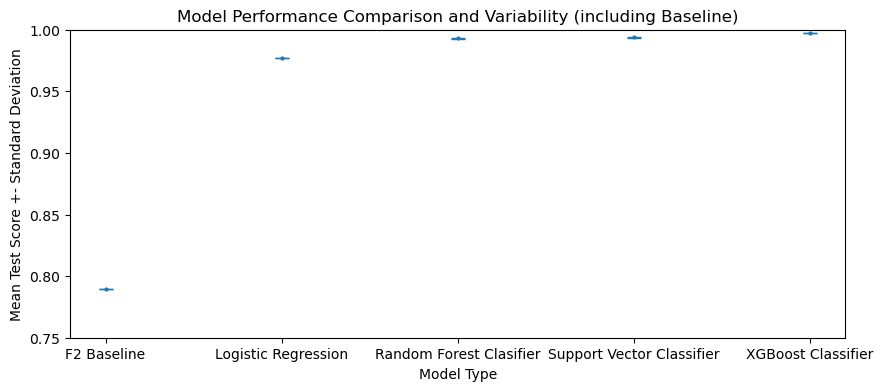

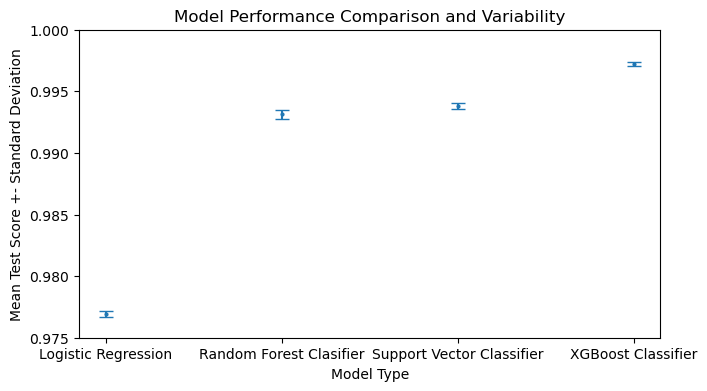

In [81]:
plt.figure(figsize = (10, 4))
plt.errorbar(x = test_scores_df.columns, y = test_scores_df.mean(axis = 0), yerr = test_scores_df.std(axis = 0), fmt = 'o', markersize = 2, capsize = 5)
plt.ylim(0.75, 1)
plt.xlabel('Model Type')
plt.ylabel('Mean Test Score +- Standard Deviation')
plt.title('Model Performance Comparison and Variability (including Baseline)')
plt.show()

plt.figure(figsize = (7.5, 4))
plt.errorbar(x = test_scores_df.columns[1:], y = test_scores_df.mean(axis = 0).iloc[1:], yerr = test_scores_df.std(axis = 0).iloc[1:], fmt = 'o', markersize = 2, capsize = 5)
plt.ylim(0.975, 1)
plt.xlabel('Model Type')
plt.ylabel('Mean Test Score +- Standard Deviation')
plt.title('Model Performance Comparison and Variability')
plt.show()

#### How many standard deviations above the baseline is the best model --> XGBoost Classifier?

The baseline score is always 0.789157, making that the mean baseline score.

The XGBoost Classifier mean score is 0.997236, with a standard deviation of 0.000171.

The difference between the two mean baseline scores is 0.997236 - 0.789157 = 0.208079.

The amount of standard deviations (of the XGBoost Classifier) between these two scores is thus 0.208079 / 0.000171 = 1216.83625731.

**Therefore, the best model is ~1216.84 standard deviations above the baseline.**

In [118]:
def plot_confusion_matrix(y_true, y_pred, title = 'Confusion Matrix', normalize = False):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1, keepdims = True)

    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Legitimate: No', 'Phishing: Yes'])
    
    fig, ax = plt.subplots(figsize = (6, 4))
    disp.plot(ax = ax, values_format = '.4f' if normalize else 'd')
    plt.title(title)
    plt.gca().xaxis.set_ticks_position('top')
    plt.tight_layout()
    plt.show()

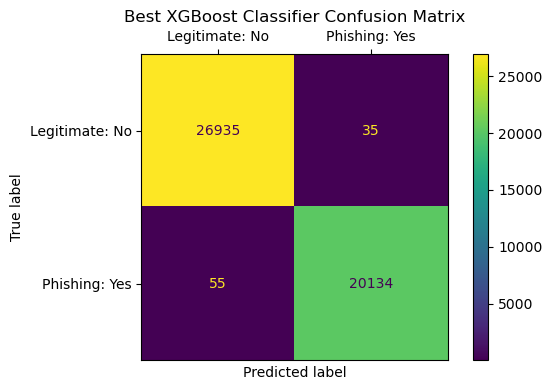

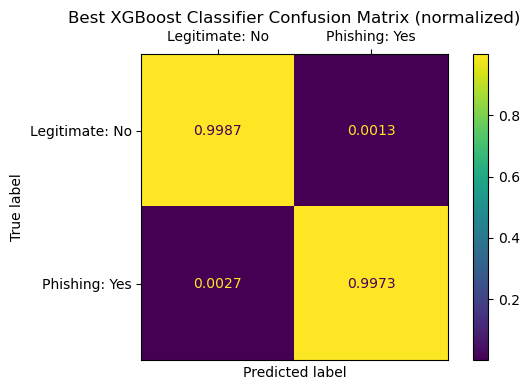

In [119]:
best_xgbc_index = np.argmax(xgbc_model_results['best_scores'])
best_xgbc_y_test = xgbc_model_results['y_test'][best_xgbc_index]
best_xgbc_y_pred = xgbc_model_results['predicted_labels'][best_xgbc_index]

plot_confusion_matrix(best_xgbc_y_test, best_xgbc_y_pred, title = 'Best XGBoost Classifier Confusion Matrix', normalize = False)
plot_confusion_matrix(best_xgbc_y_test, best_xgbc_y_pred, title = 'Best XGBoost Classifier Confusion Matrix (normalized)', normalize = True)

In [ ]:
# GLOBAL FEATURE IMPORTANCE 1

# fbeta emphasizing recall, because false negatives are more costly than false positives (i.e. not flagging a phishing URL could be worse than flagging a benign URL and the user having to override it -- the ramifications for undetected phishing are much worse)
f2_score = make_scorer(fbeta_score, beta = 2)

feature_importances = permutation_importance(xgbc_model_results['best_estimators'][best_xgbc_index], xgbc_model_results['X_test_preprocessed'][best_xgbc_index], xgbc_model_results['y_test'][best_xgbc_index], n_repeats = 30, scoring = f2_score, random_state = 42, n_jobs = -1)

                       Mean Importance
ss__LineOfCode                0.080422
ss__NoOfSelfRef               0.031078
ss__LargestLineLength         0.018865
mm__LetterRatioInURL          0.013639
ss__NoOfImage                 0.011546
ss__NoOfExternalRef           0.011183
ss__NoOfJS                    0.003919
ss__HasSocialNet              0.003458



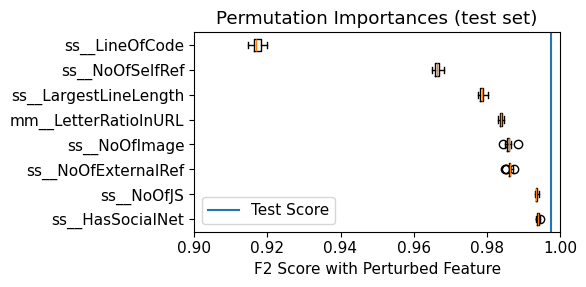

In [192]:
ordered_idx = feature_importances['importances_mean'].argsort()

mean_importances_df = pd.DataFrame(feature_importances['importances_mean'][ordered_idx], index = xgbc_model_results['X_test_preprocessed'][best_xgbc_index].columns[ordered_idx], columns = ['Mean Importance'])
print(mean_importances_df.sort_values(by = 'Mean Importance', ascending = False), end = '\n\n')

importances_df = pd.DataFrame(feature_importances['importances'][ordered_idx].T, columns = xgbc_model_results['X_test_preprocessed'][best_xgbc_index].columns[ordered_idx])

test_score = xgbc_model_results['best_scores'][best_xgbc_index]

plt.rcParams.update({'font.size': 11})
plt.figure(figsize = (6,3))
plt.boxplot(test_score - importances_df, tick_labels = importances_df.columns.to_list(), vert = False)
plt.axvline(test_score, label = 'Test Score')
plt.title("Permutation Importances (test set)")
plt.xlabel('F2 Score with Perturbed Feature')
plt.xlim(0.9, 1)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# GLOBAL FEATURE IMPORTANCE 2

xgbc_explainer = shap.TreeExplainer(xgbc_model_results['best_estimators'][best_xgbc_index])

shap_values = xgbc_explainer.shap_values(xgbc_model_results['X_test_preprocessed'][best_xgbc_index])

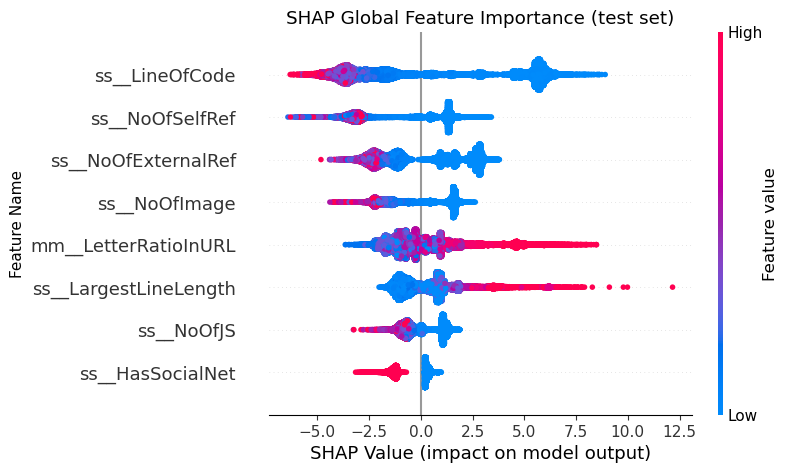

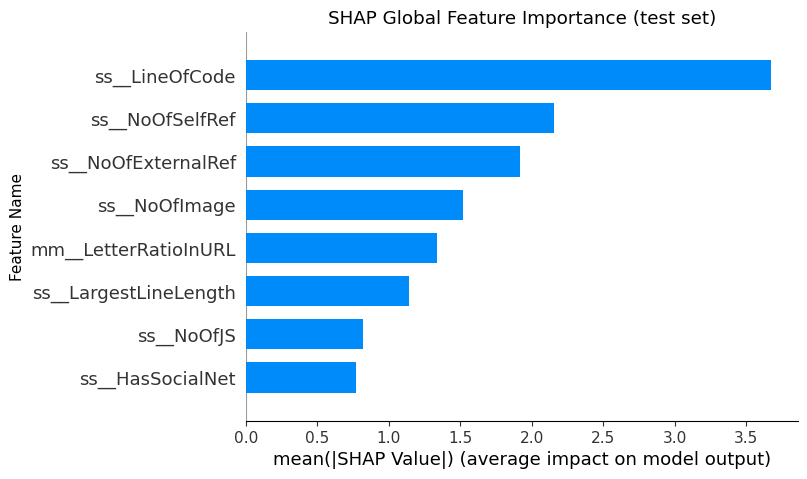

In [204]:
shap.summary_plot(shap_values, xgbc_model_results['X_test_preprocessed'][best_xgbc_index], show = False)

plt.xlabel('SHAP Value (impact on model output)')
plt.ylabel('Feature Name')
plt.title('SHAP Global Feature Importance (test set)')
plt.show()

shap.summary_plot(shap_values, xgbc_model_results['X_test_preprocessed'][best_xgbc_index], plot_type = 'bar', show = False)

plt.xlabel('mean(|SHAP Value|) (average impact on model output)')
plt.ylabel('Feature Name')
plt.title('SHAP Global Feature Importance (test set)')
plt.show()

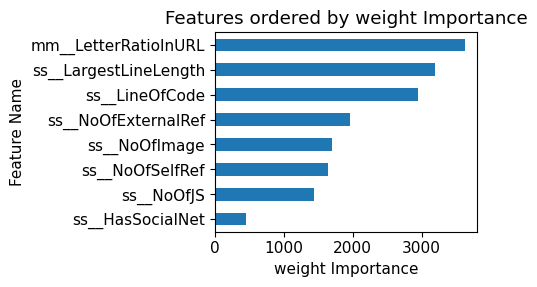

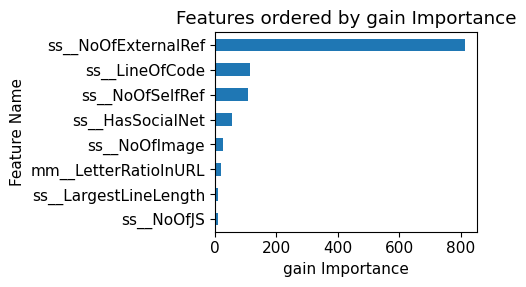

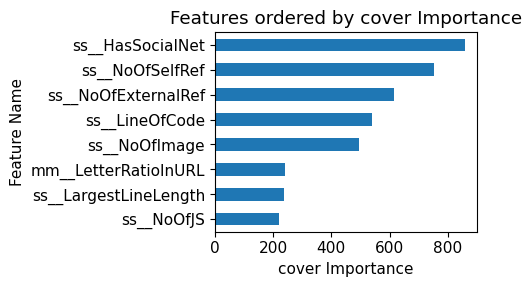

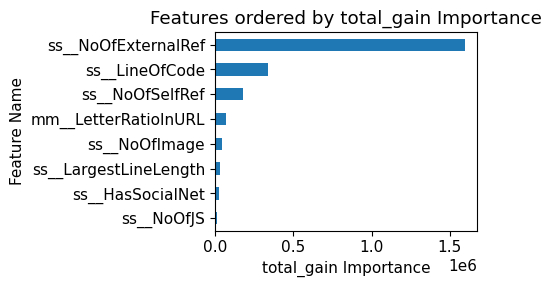

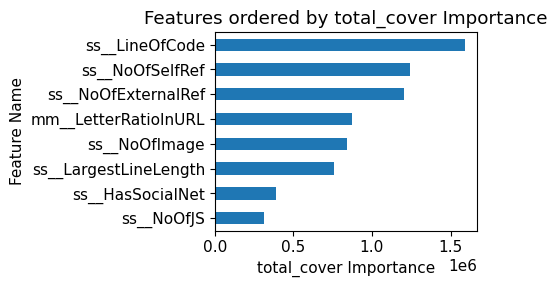

In [208]:
# GLOBAL FEATURE IMPORTANCE 3

METRICS = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
ordered_features = {}

for metric in METRICS:
    ordered_features[f'{metric}'] = pd.Series(xgbc_model_results['best_estimators'][best_xgbc_index].get_booster().get_score(importance_type = metric)).sort_values(ascending = False)

for metric, top_10_features in ordered_features.items():
    plt.figure(figsize = (5,3))
    top_10_features[::-1].plot(kind = 'barh')
    plt.title(f'Features ordered by {metric} Importance')
    plt.xlabel(f'{metric} Importance')
    plt.ylabel('Feature Name')
    plt.tight_layout()
    plt.show()